In [115]:
import os
import pypsa
import random
import requests
import numpy as np
import pandas as pd
from io import StringIO
from pathlib import Path
import matplotlib.pyplot as plt

In [222]:
date = '2024-04-19'
period = 18

In [108]:
def get_price(date, period):

    price_template = "https://data.elexon.co.uk/bmrs/api/v1/balancing/pricing/market-index?from={}T00:00Z&to={}T00:00Z&settlementPeriodFrom={}&settlementPeriodTo={}"

    url = price_template.format(date, date, period, period)
    response = requests.get(url)
    df = pd.read_csv(StringIO(response.text))

    for col1, col2 in zip(df.columns[:-1], df.columns[1:]):
        if not ('price' in col1 and 'volume' in col2):
            continue
        print(col2)

        return float(col1.split(':')[-1])


price = get_price(date, period)

volume:2690.550}


In [109]:
def get_model(date, period, layout='nodal'):
    return pypsa.Network(Path.cwd().parent / 'resources' / 'live_data' / f'{date}_{period}' / f'network_s_{layout}_solved.nc')

n = get_model(date, period)

carrier_grouper = {
    'hydro': 'hydro',
    'hydro-scheme': 'hydro',
    'wind': 'offwind',
    'floating wind': 'offwind',
    'CCGT': 'gas',
    'solar power station': 'solar',
    'PV': 'solar',
    'PHS': 'hydro',
}

n.generators['carrier'] = n.generators.carrier.map(lambda x: carrier_grouper[x] if x in carrier_grouper else x)

colors = {
    "onwind": "#235ebc",
    "offwind": "#6895dd",
    "hydro": "#298c81",
    "CHP": "#8a5751",
    "coal": "#545454",
    "biomass": "#baa741",
    "gas": "#a85522",
    "nuclear": '#ff8c00',
    "interconnector": "#8a1caf",
    "cascade": "#46caf0",
    "solar": "#f9d002",
    "battery": '#ace37f',
}

Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads


Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_eso_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_fti_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, loads


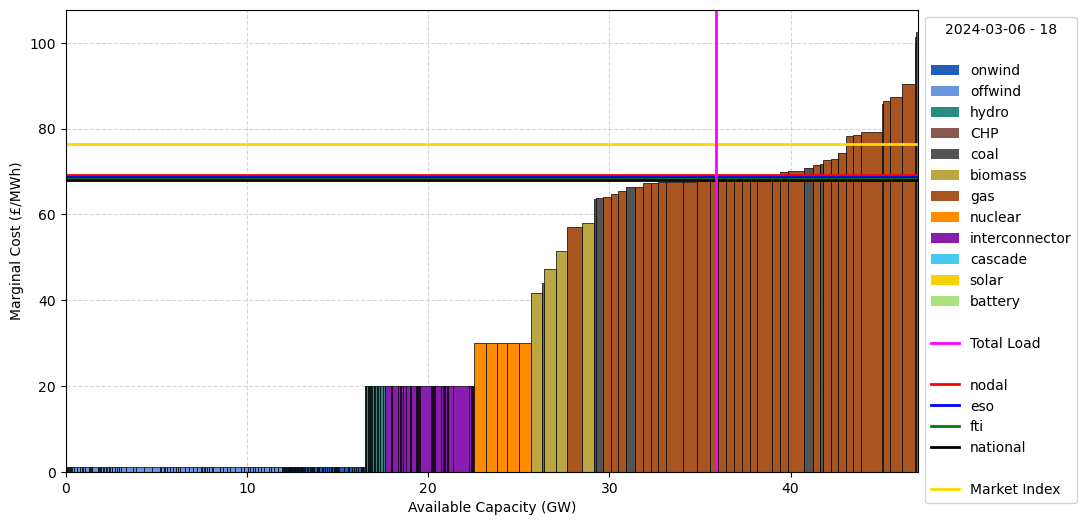

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(11, 6))


gen = n.generators.sort_values(by=['marginal_cost', 'carrier'])
gen.drop(gen[gen.p_nom == 0].index, inplace=True)

gen["p_nom"] *= 1e-3

gen['total_p_nom'] = gen['p_nom'].cumsum()

for i, (bmu, row) in enumerate(gen.iterrows()):
    # ax.bar(bmu, row['p_nom'], color=colors[row['carrier']], edgecolor='black', linewidth=0.5)
    ax.bar(
        row.total_p_nom - row.p_nom/2,
        max(row.marginal_cost, 1),
        width=row.p_nom,
        # bottom=row.total_p_nom - row.p_nom,
        color=colors[row.carrier],
        edgecolor='black',
        linewidth=0.5
        )

handles = []
labels = []
labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label=''))

for color, carrier in zip(colors.values(), colors.keys()):
    if not carrier in gen.carrier.values:
        continue

    handles.append(plt.Rectangle((0, 0), 1, 1, fc=color))
    labels.append(carrier)

labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label=''))

load_color = 'magenta'
labels.append('Total Load')
handles.append(plt.Line2D([0], [0], color=load_color, lw=2, label=''))

labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label=''))


lcolors = {
    'national': 'black',
    'eso': 'blue',
    'fti': 'green',
    'nodal': 'red',
}

for l in ['nodal', 'eso', 'fti', 'national']:
    ln = get_model(date, period, layout=l)

    max_price = ln.buses_t.marginal_price.max().max()
    ax.axhline(max_price, color=lcolors[l], lw=2)

    handles.append(plt.Line2D([0], [0], color=lcolors[l], lw=2))
    labels.append(l)

ax.axhline(price, color='gold', lw=2)
labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label=''))

labels.append('Market Index')
handles.append(plt.Line2D([0], [0], color='gold', lw=2))

ax.legend(
    handles,
    labels,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    title=f'{date} - {period}',
    )

ax.set_xlabel('Available Capacity (GW)')
ax.set_ylabel('Marginal Cost (£/MWh)')

ax.axvline(n.loads.p_set.sum() * 1e-3, color=load_color, lw=2)
ax.set_xlim(0, gen.p_nom.sum())

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

plt.show()

In [ ]:
def get_bm_data